<a href="https://colab.research.google.com/github/lucdekeijzer/Assignment_3_Spaceship_Titanic/blob/main/Assignment_3_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
dataset = 'spaceship-titanic'

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 16.7MB/s]


In [3]:
# used for debugging
!pip install -Uqq ipdb
import ipdb
%pdb on
#ipdb.set_trace()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
Automatic pdb calling has been turned ON


In [4]:
import pandas as pd
train_data_df = pd.read_csv("/content/spaceship-titanic/train.csv")
test_data_df = pd.read_csv("/content/spaceship-titanic/test.csv")
print(train_data_df)

     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa 

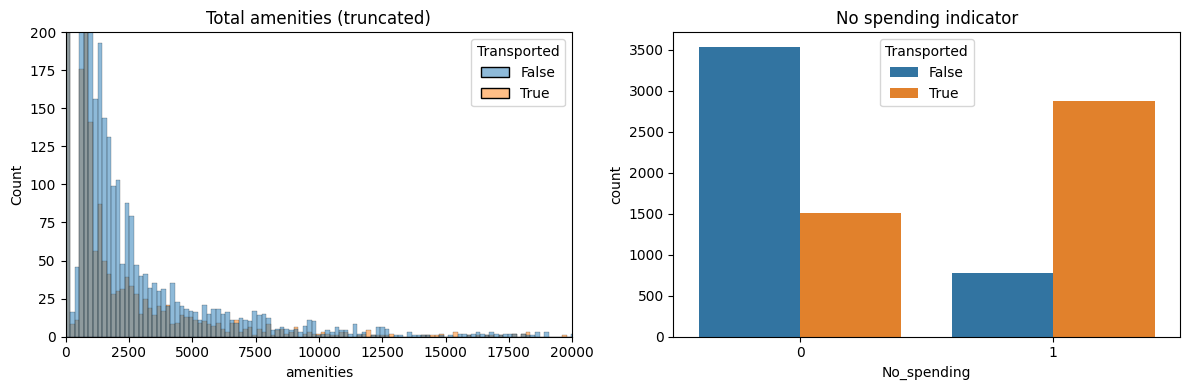

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#added the features expenditure and no spending which is based on the persons spendings on the ship
train_data_df['amenities']=train_data_df[exp_feats].sum(axis=1)
train_data_df['No_spending']=(train_data_df['amenities']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data_df, x='amenities', hue='Transported', bins=200)
plt.title('Total amenities (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_data_df, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

In [6]:
print(train_data_df)

     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa 

In [7]:
train_data_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
amenities         0
No_spending       0
dtype: int64

In [8]:
# Encoding
from sklearn.preprocessing import LabelEncoder

# Encoding
# from sklearn.preprocessing import OneHotEncoder
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# # encode the entire training dataset
# columns_to_encode = ["PassengerId", "HomePlanet", "Destination", "Cabin", "Name"]
# oneHotEncoder.fit(X[columns_to_encode])
# # encode the specified columns individually
# X[columns_to_encode] = oneHotEncoder.transform(X[columns_to_encode])
bool_columns = ['CryoSleep', 'VIP', 'Transported']

for col in bool_columns:
    train_data_df[col] = train_data_df[col].astype(bool)

categorical_features=['PassengerId',"HomePlanet",'Destination','Cabin','Name']
label_encoder = LabelEncoder()
for feature in categorical_features:
 train_data_df[feature] = label_encoder.fit_transform(train_data_df[feature])
print(train_data_df)

      PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0               0           1      False    149            2  39.0  False   
1               1           0      False   2184            2  24.0  False   
2               2           1      False      1            2  58.0   True   
3               3           1      False      1            2  33.0  False   
4               4           0      False   2186            2  16.0  False   
...           ...         ...        ...    ...          ...   ...    ...   
8688         8688           1      False    146            0  41.0   True   
8689         8689           0       True   5280            1  18.0  False   
8690         8690           0      False   5285            2  26.0  False   
8691         8691           1      False   2131            0  32.0  False   
8692         8692           1      False   2131            2  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Name  Transport

In [ ]:
for feature in categorical_features:
 print('max value of feature '+feature+' is '+str(train_data_df[feature].max()))

In [16]:
# print(len(train_data_df))
# train_data_df_filled_na = train_data_df.fillna(method = "ffill")
# print(len(train_data_df))

# categorical_columns = ['HomePlanet', 'Cabin', 'Destination', 'Name']

# for col in categorical_columns:
#     train_data_df[col] = pd.factorize(train_data_df[col])[0]


for col in categorical_features:
     train_data_df.loc[:,col].fillna( train_data_df.loc[:,col].mode(), inplace=True)

numerical_features=list(set(train_data_df.columns)-set([*categorical_features,'Transported']))
print(numerical_features)

for col in numerical_features:
     train_data_df.loc[:,col].fillna( train_data_df.loc[:,col].mean(), inplace=True)

print(train_data_df)

['Age', 'ShoppingMall', 'VRDeck', 'RoomService', 'FoodCourt', 'amenities', 'VIP', 'No_spending', 'CryoSleep', 'Spa']
      PassengerId  HomePlanet  CryoSleep     Cabin  Destination   Age    VIP  \
0        0.000000    0.333333      False  0.022713     0.666667  39.0  False   
1        0.000115    0.000000      False  0.332927     0.666667  24.0  False   
2        0.000230    0.333333      False  0.000152     0.666667  58.0   True   
3        0.000345    0.333333      False  0.000152     0.666667  33.0  False   
4        0.000460    0.000000      False  0.333232     0.666667  16.0  False   
...           ...         ...        ...       ...          ...   ...    ...   
8688     0.999540    0.333333      False  0.022256     0.000000  41.0   True   
8689     0.999655    0.000000       True  0.804878     0.333333  18.0  False   
8690     0.999770    0.000000      False  0.805640     0.666667  26.0  False   
8691     0.999885    0.333333      False  0.324848     0.000000  32.0  False   
869

In [17]:
train_data_df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
amenities       0
No_spending     0
dtype: int64

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(train_data_df["RoomService"].shape)


# Initialize StandardScaler
standardScaler = StandardScaler()
minMaxScaler=MinMaxScaler()

# Transform both Train and Validation data
minMaxScaler.fit(train_data_df[categorical_features])
train_data_df[categorical_features] = minMaxScaler.transform(train_data_df[categorical_features])

standardScaler.fit(train_data_df[numerical_features])
train_data_df[numerical_features] = standardScaler.transform(train_data_df[numerical_features])

(8693,)


In [19]:
print(train_data_df.dtypes)

PassengerId     float64
HomePlanet      float64
CryoSleep       float64
Cabin           float64
Destination     float64
Age             float64
VIP             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name            float64
Transported        bool
amenities       float64
No_spending     float64
dtype: object


      PassengerId  HomePlanet  CryoSleep     Cabin  Destination       Age  \
0        0.000000    0.333333  -0.773480  0.022713     0.666667  0.709437   
1        0.000115    0.000000  -0.773480  0.332927     0.666667 -0.336717   
2        0.000230    0.333333  -0.773480  0.000152     0.666667  2.034566   
3        0.000345    0.333333  -0.773480  0.000152     0.666667  0.290975   
4        0.000460    0.000000  -0.773480  0.333232     0.666667 -0.894666   
...           ...         ...        ...       ...          ...       ...   
8688     0.999540    0.333333  -0.773480  0.022256     0.000000  0.848924   
8689     0.999655    0.000000   1.292858  0.804878     0.333333 -0.755179   
8690     0.999770    0.000000  -0.773480  0.805640     0.666667 -0.197230   
8691     0.999885    0.333333  -0.773480  0.324848     0.000000  0.221232   
8692     1.000000    0.333333  -0.773480  0.324848     0.666667  1.058155   

           VIP  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \

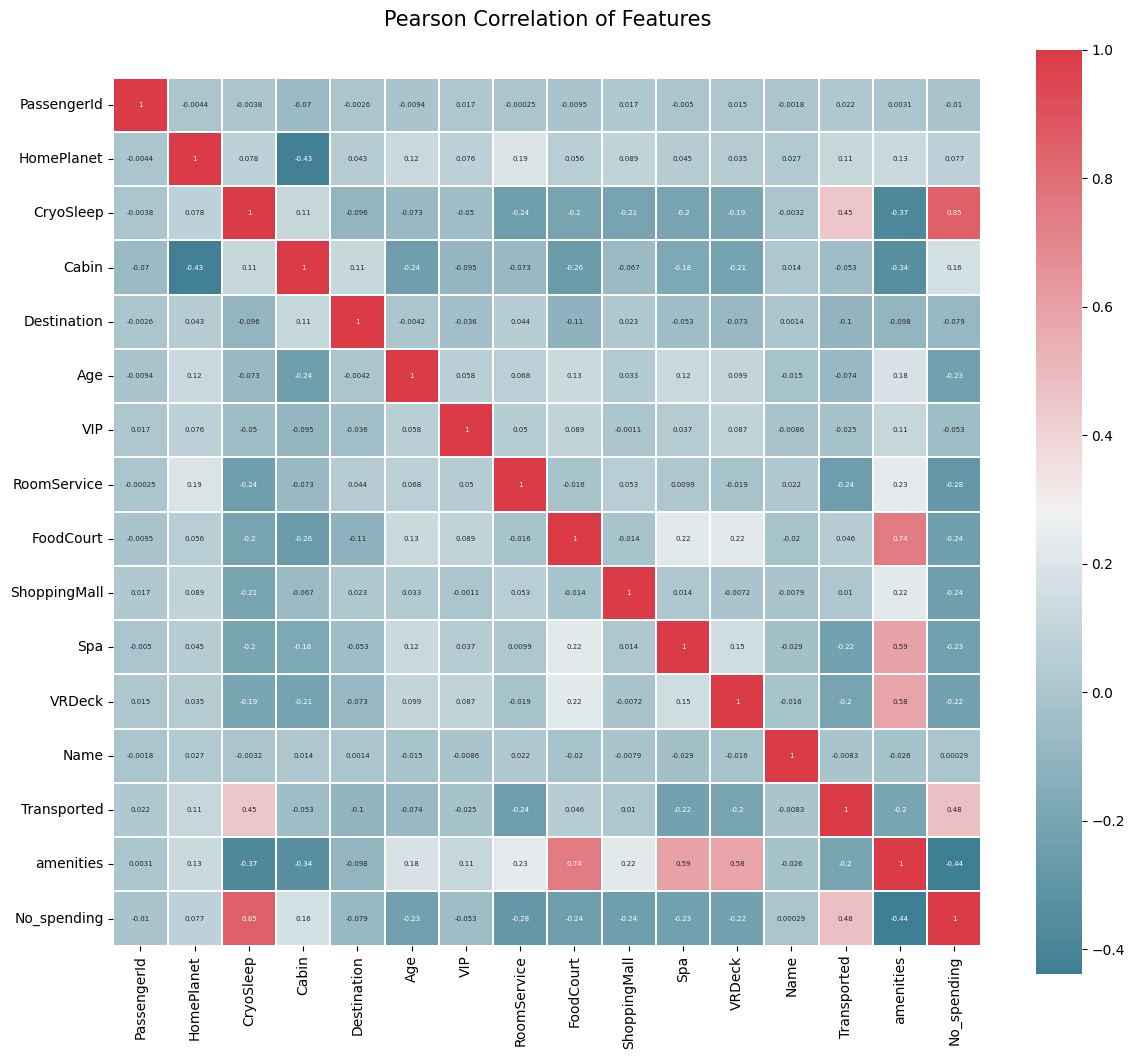

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(

        df.corr(numeric_only=True),
        cmap = colormap,
        square=True,

        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize': 5 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_data_df)
print(train_data_df)

In [21]:
len(train_data_df)
X = train_data_df.loc[:, train_data_df.columns != 'Transported']
y = train_data_df['Transported']

In [22]:
print(X.dtypes)

PassengerId     float64
HomePlanet      float64
CryoSleep       float64
Cabin           float64
Destination     float64
Age             float64
VIP             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name            float64
amenities       float64
No_spending     float64
dtype: object


In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3)

In [27]:
# Perform PCA

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# pca = PCA()  # initializing the pca
# pca.set_params(n_components = .99)    # configure the number of components
# X_train = pca.fit_transform(X_train)
# X_val = pca.transform(X_val)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC
svc = SVC()

svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_val, y_val))


# Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)

# # Perform grid search on training data
# grid_search.fit(X_train[:50], y_train[:50])

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


0.7930977814297453
0.7841257668711656


In [28]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

prediction = model.predict(X_val)

correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = correct_pred/total_pred
print("Accuracy:", acc)

Accuracy: 0.7822085889570553


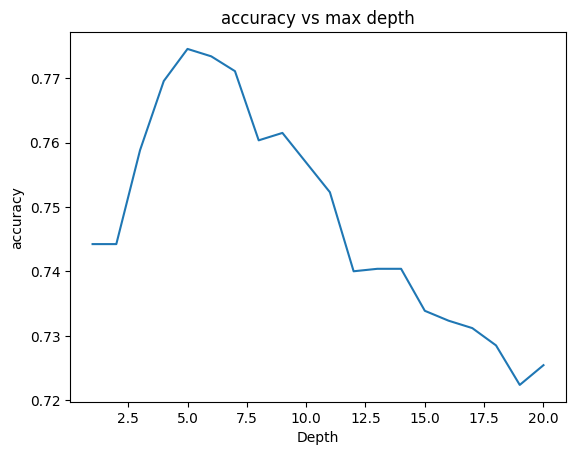

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

acc = []
depth = [i for i in range(1, 21)]

for d in depth:
    model = DecisionTreeClassifier(random_state = 42, max_depth=d)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    correct_pred = (prediction == y_val).sum()
    total_pred = len(y_val)

    acc.append(correct_pred/total_pred)


plt.plot(depth, acc)
plt.xlabel("Depth")
plt.ylabel("accuracy")
plt.title("accuracy vs max depth")
plt.show()



In [48]:
print(max(acc))

0.7745398773006135


In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

prediction = model.predict(X_val)
correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = (correct_pred/total_pred)
print("Accuracy:", acc)

Accuracy: 0.7983128834355828


In [55]:
from sklearn.ensemble import RandomForestClassifier



# randomforest with gridsearch

model = RandomForestClassifier(random_state=42)


param_grid = {
  'max_depth': [10, 15, 18],
  'n_estimators': [200, 250, 350, 400],  # Number of trees in the forest
  'criterion': ['gini', 'entropy']
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=gini, max_depth=10, n_estimators=200;, score=0.799 total time=   2.3s
[CV 2/5] END criterion=gini, max_depth=10, n_estimators=200;, score=0.779 total time=   2.3s
[CV 3/5] END criterion=gini, max_depth=10, n_estimators=200;, score=0.802 total time=   3.3s
[CV 4/5] END criterion=gini, max_depth=10, n_estimators=200;, score=0.790 total time=   2.6s
[CV 5/5] END criterion=gini, max_depth=10, n_estimators=200;, score=0.796 total time=   3.3s
[CV 1/5] END criterion=gini, max_depth=10, n_estimators=250;, score=0.799 total time=   2.8s
[CV 2/5] END criterion=gini, max_depth=10, n_estimators=250;, score=0.781 total time=   3.2s
[CV 3/5] END criterion=gini, max_depth=10, n_estimators=250;, score=0.801 total time=   3.7s
[CV 4/5] END criterion=gini, max_depth=10, n_estimators=250;, score=0.791 total time=   2.9s
[CV 5/5] END criterion=gini, max_depth=10, n_estimators=250;, score=0.794 total time=   3.4s
[CV 1/5]

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(max_depth=7, random_state=42)
model.fit(X_train, y_train)

print(model.score(X_val, y_val))

importances = model.feature_importances_

feature_names = train_data_df.columns.tolist()

importance_feature_pairs = zip(importances, feature_names)

# Sort the pairs based on importance values in ascending order
sorted_pairs = sorted(importance_feature_pairs)

# Print the sorted feature importances
for importance, feature_name in sorted_pairs:
    print(f"{feature_name}: importance = {importance}")

0.7960122699386503
VIP: importance = 0.003670751703173752
CryoSleep: importance = 0.010303670174386817
Destination: importance = 0.012621608742364843
RoomService: importance = 0.03653259413507017
HomePlanet: importance = 0.040944980586802404
Age: importance = 0.048667744481794624
VRDeck: importance = 0.05189862453778839
Name: importance = 0.05578116529529641
Spa: importance = 0.0598729736783342
PassengerId: importance = 0.0616569970374378
ShoppingMall: importance = 0.07941311952176211
FoodCourt: importance = 0.08852065522503418
Cabin: importance = 0.11493592202114972
amenities: importance = 0.1322993977044574
Transported: importance = 0.2028797951551472


In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


model = make_pipeline(
    MLPClassifier(
        hidden_layer_sizes=(256, 256, 256, 256, 256, 256),  # Architecture matching your Keras model
        activation='relu',  # 'leaky_relu' is not directly supported in scikit-learn
        alpha=0.01,  # Regularization strength
        solver='adam',  # Optimization algorithm
        random_state=42,
        max_iter=1000,  # Maximum number of iterations
        early_stopping=True,  # Enable early stopping to prevent overfitting
        n_iter_no_change=30,  # Number of iterations with no improvement before stopping
        verbose=True
    )
)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_val, y_val)
print("Test Accuracy:"+str(accuracy))

Iteration 1, loss = 0.54283567
Validation score: 0.743842
Iteration 2, loss = 0.47881527
Validation score: 0.765189
Iteration 3, loss = 0.45528442
Validation score: 0.760263
Iteration 4, loss = 0.44269329
Validation score: 0.771757
Iteration 5, loss = 0.43934278
Validation score: 0.765189
Iteration 6, loss = 0.43763882
Validation score: 0.756979
Iteration 7, loss = 0.43130216
Validation score: 0.763547
Iteration 8, loss = 0.43622503
Validation score: 0.770115
Iteration 9, loss = 0.43094477
Validation score: 0.770115
Iteration 10, loss = 0.42167557
Validation score: 0.768473
Iteration 11, loss = 0.42244384
Validation score: 0.752053
Iteration 12, loss = 0.42157172
Validation score: 0.760263
Iteration 13, loss = 0.41637409
Validation score: 0.771757
Iteration 14, loss = 0.41520131
Validation score: 0.766831
Iteration 15, loss = 0.41850280
Validation score: 0.768473
Iteration 16, loss = 0.41108645
Validation score: 0.760263
Iteration 17, loss = 0.41073265
Validation score: 0.765189
Iterat

In [38]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
print(nb_classifier.score(X_val, y_val))

0.7285276073619632


In [49]:
from sklearn.neighbors import KNeighborsClassifier
k_max = 15  # Setting the maximum number of neighbours considered
knn_errs_val = []
for k in range(1,k_max+1):
 model = KNeighborsClassifier(n_neighbors=k)
 model.fit(X_train, y_train)
 err = model.score(X_val, y_val)
 print(f"Number of neighbours: k={k}, validation accuracy: {err}")
 knn_errs_val.append(err)
print("Grid search done!")

Number of neighbours: k=1, validation accuracy: 0.7208588957055214
Number of neighbours: k=2, validation accuracy: 0.7346625766871165
Number of neighbours: k=3, validation accuracy: 0.7526840490797546
Number of neighbours: k=4, validation accuracy: 0.7511503067484663
Number of neighbours: k=5, validation accuracy: 0.7572852760736196
Number of neighbours: k=6, validation accuracy: 0.758819018404908
Number of neighbours: k=7, validation accuracy: 0.7638036809815951
Number of neighbours: k=8, validation accuracy: 0.7603527607361963
Number of neighbours: k=9, validation accuracy: 0.7672546012269938
Number of neighbours: k=10, validation accuracy: 0.7691717791411042
Number of neighbours: k=11, validation accuracy: 0.7730061349693251
Number of neighbours: k=12, validation accuracy: 0.7707055214723927
Number of neighbours: k=13, validation accuracy: 0.772239263803681
Number of neighbours: k=14, validation accuracy: 0.7695552147239264
Number of neighbours: k=15, validation accuracy: 0.76993865

In [53]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
print("Score: "+str(model.score(X_val,y_val)))

Score: 0.7887269938650306


In [54]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


svc = SVC(probability=True)
rf_classifier = RandomForestClassifier(n_estimators = 250,max_depth=15)
log_reg = LogisticRegression()
gradientBoostingClassifier = GradientBoostingClassifier(max_depth=7, random_state=42)
xgb_model = XGBClassifier(random_state=42)
decision_tree = DecisionTreeClassifier(random_state = 42, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=11)


# ann_model = make_pipeline(
#     MLPClassifier(
#         hidden_layer_sizes=(256, 256, 256, 256, 256, 256),  # Architecture matching your Keras model
#         activation='relu',  # 'leaky_relu' is not directly supported in scikit-learn
#         alpha=0.01,  # Regularization strength
#         solver='adam',  # Optimization algorithm
#         random_state=42,
#         max_iter=1000,  # Maximum number of iterations
#         early_stopping=True,  # Enable early stopping to prevent overfitting
#         n_iter_no_change=30,  # Number of iterations with no improvement before stopping
#         verbose=True
#     )
# )

# Initialize Voting Classifier
voting_classifier = VotingClassifier(estimators=[('GradientBoostingClassifier', gradientBoostingClassifier),
 ('Random Forest', rf_classifier),
  ("Naive Bayes", nb_classifier),
   ("Log Reg", log_reg),
    ("svc", svc),
    ("xgb_model", xgb_model),
    ('decision_tree',decision_tree),
    ('knn',knn)],
     voting='soft')
voting_classifier.fit(X_train, y_train)
print('The accuracy on the test subset: {:.3f}'.format(voting_classifier.score(X_val, y_val)))

The accuracy on the test subset: 0.795


In [51]:
print(test_data_df)

     PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth       True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth      False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa       True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa      False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth      False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...        ...       ...            ...   ...    ...   
4272     9266_02      Earth       True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth      False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars       True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa      False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth       True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingM